In [12]:
import os

import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import cv2

# Implementation and Training of VideoColorizer UNet model

First without optical flow


Inputs:
- previous frame: L, ab channels
- current frame: L channel

Outputs:
- current frame: ab channels

In [13]:
def cartToPol(x, y):  
    # Convert cartesian to polar coordinates (for optical flow)
    
    ang = np.arctan2(y, x)
    mag = np.hypot(x, y)
    return mag, ang

def uv_2_rgb(image_uv, resize=False):
    # Convert the optical flow field into HSV Polar coordinate representation

    uv_shape = image_uv.shape
    hsv = np.zeros((uv_shape[0], uv_shape[1], 3))
    hsv[..., 1] = 255

    # Encoding: convert the algorithm's output into Polar coordinates
    mag, ang = cartToPol(image_uv[..., 0], image_uv[..., 1])
    # Use Hue and Value to encode the Optical Flow
    hsv[..., 0] = (ang+np.pi) * 180 / ( 2 * np.pi )
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    #print(hsv)
    hsv = np.round(hsv).astype(np.uint8)
    #print(hsv)
    # Convert HSV to RGB (BGR) color representation
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return bgr

## 1. Data Loading

In [15]:
from DataLoad import CustomImageDataset, data_to_images

In [16]:
use_flow=False

dataset = CustomImageDataset(resolution='176p', use_flow=use_flow)

dataset_size = len(dataset)
print('Dataset size:', dataset_size)

vid labels: ['basketball-game', 'bmx-rider', 'butterfly', 'car-competition', 'cat', 'chairlift', 'circus', 'dog-competition', 'dolphins-show', 'drone-flying', 'ducks', 'giraffes', 'gym-ball', 'helicopter-landing', 'horse-race', 'hurdles-race', 'ice-hockey', 'jet-ski', 'juggling-selfie', 'kids-robot', 'mantaray', 'mascot', 'motorbike-race', 'obstacles', 'plane-exhibition', 'robot-battle', 'snowboard-race', 'swimmer', 'tram', 'trucks-race']
Dataset size: 2264


In [17]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 4, 320, 176])
Labels batch shape: torch.Size([64, 2, 320, 176])


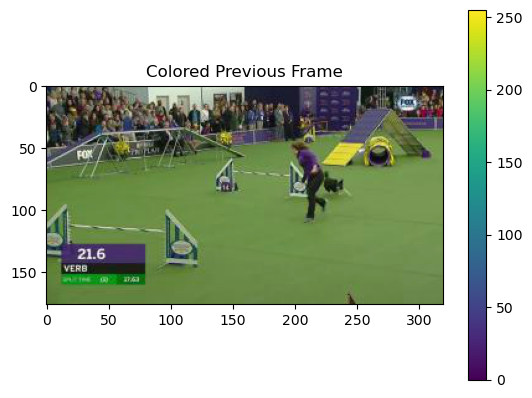

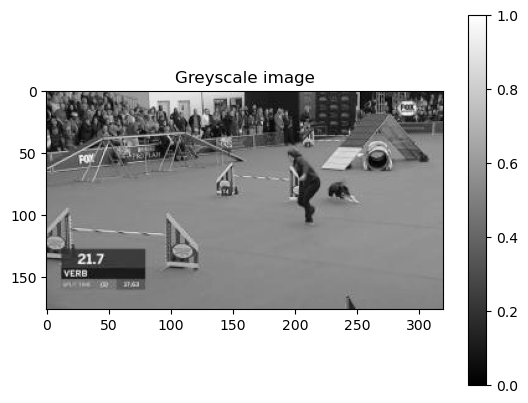

In [18]:
train_features, train_labels = next(iter(train_dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

col_img, flow_img, grey_img = data_to_images(train_features[0], train_labels[0], use_flow=use_flow)

im = plt.imshow(col_img)
cbar = plt.colorbar(im)
plt.title('Colored Previous Frame')
plt.show()

im = plt.imshow(grey_img, cmap='gray')
cbar = plt.colorbar(im)
plt.title('Greyscale image')
plt.show()


if use_flow:
    flow_rgb = uv_2_rgb(flow_img)

    im = plt.imshow(flow_rgb)
    cbar = plt.colorbar(im)
    plt.title('Optical flow')
    plt.show()

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    for ax in enumerate(axs):
        ax[1].axis('off')
        ax[1].set_title('Flow channel ' + str(ax[0]))
        im = ax[1].imshow(flow_img[:, :, ax[0]], cmap='gray')
        cbar = fig.colorbar(im, ax=ax[1])
        
    plt.show()

## 2. Model Definition

In [19]:
from Model_UNet import UNet

torch.cuda.is_available()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.cuda.device_count())
print(torch.cuda.current_device())
device

1
0


device(type='cuda')

In [20]:
#initialize model
model = UNet()
model.to(device)

# Hyperparameters
learning_rate = 1e-3
batch_size = 16
epochs = 5

# Initialize the loss function
loss_fn = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Data loader
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [21]:
def train_loop(dataloader, model, loss_fn, optimizer, verbose=False):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        if verbose:
            print('batch No:', batch)
            print('X shape:', X.shape)
            print('y shape:', y.shape)
        
        # Compute prediction and loss
        if torch.cuda.is_available():
            X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [22]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 0.303582  [   16/ 2264]
loss: 0.002645  [ 1616/ 2264]
Epoch 2
-------------------------------
loss: 0.002105  [   16/ 2264]
loss: 0.000292  [ 1616/ 2264]
Epoch 3
-------------------------------
loss: 0.000252  [   16/ 2264]
loss: 0.000344  [ 1616/ 2264]
Epoch 4
-------------------------------
loss: 0.000697  [   16/ 2264]
loss: 0.000334  [ 1616/ 2264]
Epoch 5
-------------------------------
loss: 0.000322  [   16/ 2264]
loss: 0.000485  [ 1616/ 2264]
Epoch 6
-------------------------------
loss: 0.000291  [   16/ 2264]
loss: 0.000384  [ 1616/ 2264]
Epoch 7
-------------------------------
loss: 0.000394  [   16/ 2264]
loss: 0.000474  [ 1616/ 2264]
Epoch 8
-------------------------------
loss: 0.000406  [   16/ 2264]
loss: 0.000246  [ 1616/ 2264]
Epoch 9
-------------------------------
loss: 0.000422  [   16/ 2264]
loss: 0.000301  [ 1616/ 2264]
Epoch 10
-------------------------------
loss: 0.000361  [   16/ 2264]
loss: 0.000495  [ 1616/ 2264]

Feature batch shape: torch.Size([16, 4, 320, 176])
Labels batch shape: torch.Size([16, 2, 320, 176])
torch.Size([16, 2, 320, 176])
torch.Size([176, 320, 4])
torch.Size([176, 320, 2])


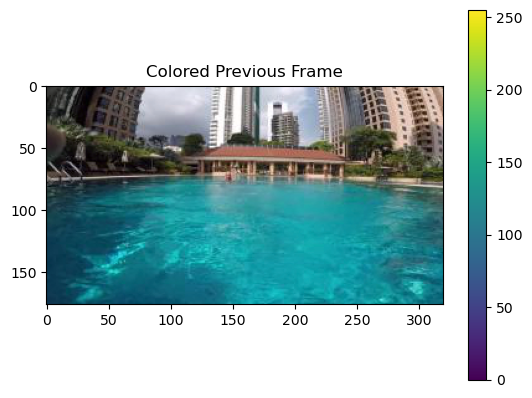

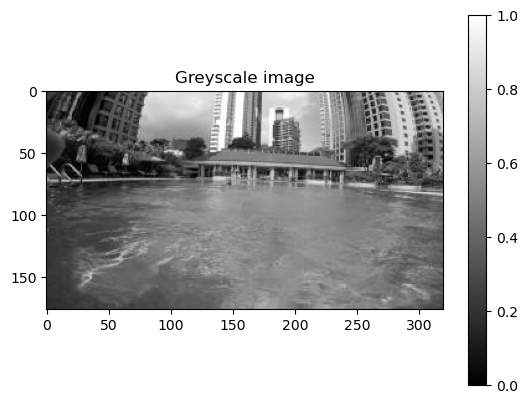

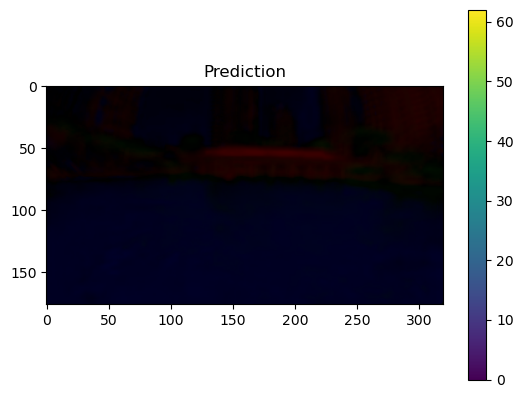

In [34]:
train_features, train_labels = next(iter(train_dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

prediction = model(train_features.to(device))
prediction = prediction.cpu()
prediction = prediction.detach()
#prediction = prediction.numpy()
print(prediction.shape)


col_img, flow_img, grey_img, pred_img = data_to_images(train_features[0], prediction[0], use_flow=use_flow, input_only=False)

im = plt.imshow(col_img)
cbar = plt.colorbar(im)
plt.title('Colored Previous Frame')
plt.show()

im = plt.imshow(grey_img, cmap='gray')
cbar = plt.colorbar(im)
plt.title('Greyscale image')
plt.show()




im = plt.imshow(pred_img)
cbar = plt.colorbar(im)
plt.title('Prediction')
plt.show()
